
# 🎬 01 — EDA & Hipóteses (PProductions)

Este notebook realiza uma **Análise Exploratória de Dados (EDA)** na base cinematográfica entregue em CSV.
O objetivo é entender as principais características dos filmes, levantar hipóteses e orientar a **PProductions**
sobre quais tipos de filmes tendem a performar melhor.

> **Entrada esperada**: `data/movies.csv` contendo as colunas:
> `Series_Title, Released_Year, Certificate, Runtime, Genre, IMDB_Rating, Overview, Meta_score, Director, Star1, Star2, Star3, Star4, No_of_Votes, Gross`.


In [1]:

# Imports
import warnings
warnings.filterwarnings("ignore")

import math
import re
from collections import Counter

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from wordcloud import WordCloud

# Display configs
pd.set_option("display.max_columns", 100)
pd.set_option("display.width", 160)

# Inline plots (no seaborn for portability)
%matplotlib inline



## 1. Carregamento dos dados


In [3]:

# Ajuste o caminho se necessário
DATA_PATH = "../data/movies.csv"

df = pd.read_csv(DATA_PATH)
print(f"Shape: {df.shape}")
df.head(3)


Shape: (999, 16)


,Unnamed: 0,Series_Title,Released_Year,Certificate,Runtime,Genre,IMDB_Rating,Overview,Meta_score,Director,Star1,Star2,Star3,Star4,No_of_Votes,Gross
0,1,The Godfather,1972,A,175 min,"Crime, Drama",9.2,An organized crime dynasty's aging patriarch t...,100.0,Francis Ford Coppola,Marlon Brando,Al Pacino,James Caan,Diane Keaton,1620367,"134,966,411"
1,2,The Dark Knight,2008,UA,152 min,"Action, Crime, Drama",9.0,When the menace known as the Joker wreaks havo...,84.0,Christopher Nolan,Christian Bale,Heath Ledger,Aaron Eckhart,Michael Caine,2303232,"534,858,444"
2,3,The Godfather: Part II,1974,A,202 min,"Crime, Drama",9.0,The early life and career of Vito Corleone in ...,90.0,Francis Ford Coppola,Al Pacino,Robert De Niro,Robert Duvall,Diane Keaton,1129952,"57,300,000"


In [4]:

# Visão geral do schema
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 999 entries, 0 to 998
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Unnamed: 0     999 non-null    int64  
 1   Series_Title   999 non-null    object 
 2   Released_Year  999 non-null    object 
 3   Certificate    898 non-null    object 
 4   Runtime        999 non-null    object 
 5   Genre          999 non-null    object 
 6   IMDB_Rating    999 non-null    float64
 7   Overview       999 non-null    object 
 8   Meta_score     842 non-null    float64
 9   Director       999 non-null    object 
 10  Star1          999 non-null    object 
 11  Star2          999 non-null    object 
 12  Star3          999 non-null    object 
 13  Star4          999 non-null    object 
 14  No_of_Votes    999 non-null    int64  
 15  Gross          830 non-null    object 
dtypes: float64(2), int64(2), object(12)
memory usage: 125.0+ KB


In [9]:

# Estatísticas descritivas (apenas numéricas neste bloco)
df.describe(include=[np.number]).T


,count,mean,std,min,25%,50%,75%,max
Unnamed: 0,999.0,500.000000,288.530761,1.0,250.5,500.0,749.5,999.0
IMDB_Rating,999.0,7.947948,0.272290,7.6,7.7,7.9,8.1,9.2
Meta_score,842.0,77.969121,12.383257,28.0,70.0,79.0,87.0,100.0
No_of_Votes,999.0,271621.422422,320912.621055,25088.0,55471.5,138356.0,373167.5,2303232.0



## 2. Limpeza & Parsing de colunas
Transformações principais:
- **Runtime** → minutos (inteiro)
- **Gross** → número (float), removendo separadores
- **Released_Year** → inteiro
- **Genre** → lista de gêneros + gênero principal (`Genre_Primary`)


In [10]:

def parse_runtime_to_minutes(runtime):
    if pd.isna(runtime):
        return np.nan
    if isinstance(runtime, (int, float)):
        return int(runtime) if runtime > 0 else np.nan
    m = re.search(r"(\d+)", str(runtime))
    return int(m.group(1)) if m else np.nan

def parse_gross_to_number(gross):
    if gross is None:
        return np.nan
    if isinstance(gross, (int, float)):
        return float(gross)
    s = str(gross).strip()
    if s == "":
        return np.nan
    # Remove separadores comuns (milhares/pontos/virgulas)
    s = s.replace(",", "").replace(".", "")
    return float(s) if s.isdigit() else np.nan

def split_genre(genre):
    if pd.isna(genre):
        return []
    parts = [g.strip() for g in str(genre).split(",") if g.strip()]
    return parts

def clean_dataframe(df):
    df = df.copy()
    # Runtime → minutos
    df["Runtime_min"] = df["Runtime"].apply(parse_runtime_to_minutes)
    # Gross → numérico
    df["Gross_num"] = df["Gross"].apply(parse_gross_to_number)
    # Ano → inteiro
    df["Released_Year_int"] = pd.to_numeric(df["Released_Year"], errors="coerce").astype("Int64")
    # Gêneros
    df["Genre_List"] = df["Genre"].apply(split_genre)
    df["Genre_Primary"] = df["Genre_List"].apply(lambda lst: lst[0] if lst else np.nan)
    return df

dfc = clean_dataframe(df)
dfc.head(3)


,Unnamed: 0,Series_Title,Released_Year,Certificate,Runtime,Genre,IMDB_Rating,Overview,Meta_score,Director,Star1,Star2,Star3,Star4,No_of_Votes,Gross,Runtime_min,Gross_num,Released_Year_int,Genre_List,Genre_Primary
0,1,The Godfather,1972,A,175 min,"Crime, Drama",9.2,An organized crime dynasty's aging patriarch t...,100.0,Francis Ford Coppola,Marlon Brando,Al Pacino,James Caan,Diane Keaton,1620367,"134,966,411",175,134966411.0,1972,"[Crime, Drama]",Crime
1,2,The Dark Knight,2008,UA,152 min,"Action, Crime, Drama",9.0,When the menace known as the Joker wreaks havo...,84.0,Christopher Nolan,Christian Bale,Heath Ledger,Aaron Eckhart,Michael Caine,2303232,"534,858,444",152,534858444.0,2008,"[Action, Crime, Drama]",Action
2,3,The Godfather: Part II,1974,A,202 min,"Crime, Drama",9.0,The early life and career of Vito Corleone in ...,90.0,Francis Ford Coppola,Al Pacino,Robert De Niro,Robert Duvall,Diane Keaton,1129952,"57,300,000",202,57300000.0,1974,"[Crime, Drama]",Crime


In [11]:

# Missing values overview
mv = dfc.isna().mean().sort_values(ascending=False)
mv.to_frame("missing_ratio").head(15)


,missing_ratio
Gross_num,0.169169
Gross,0.169169
Meta_score,0.157157
Certificate,0.101101
Released_Year_int,0.001001
Unnamed: 0,0.000000
Star3,0.000000
Genre_List,0.000000
Runtime_min,0.000000
No_of_Votes,0.000000



## 3. Distribuições básicas


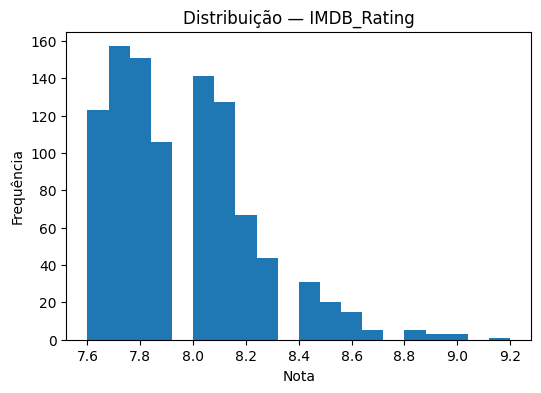

In [12]:

fig = plt.figure(figsize=(6,4))
plt.hist(dfc["IMDB_Rating"].dropna(), bins=20)
plt.title("Distribuição — IMDB_Rating")
plt.xlabel("Nota")
plt.ylabel("Frequência")
plt.show()


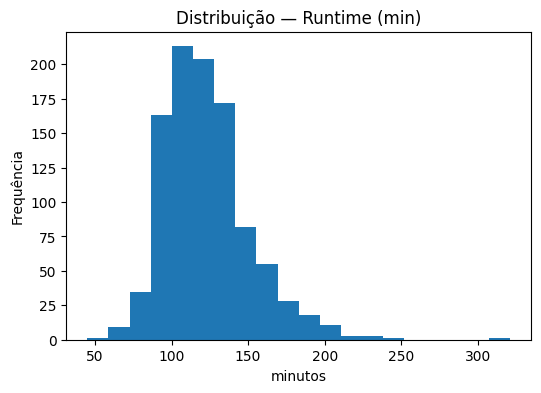

In [13]:

fig = plt.figure(figsize=(6,4))
plt.hist(dfc["Runtime_min"].dropna(), bins=20)
plt.title("Distribuição — Runtime (min)")
plt.xlabel("minutos")
plt.ylabel("Frequência")
plt.show()


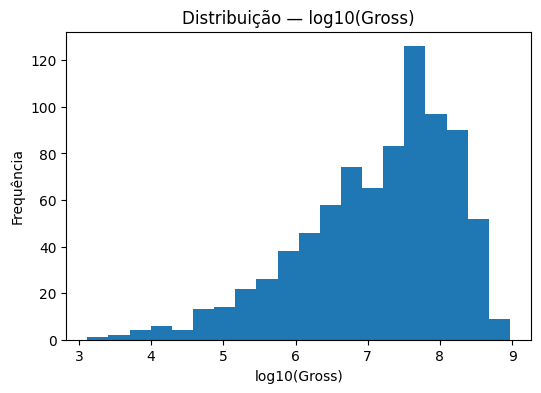

In [14]:

fig = plt.figure(figsize=(6,4))
vals = dfc["Gross_num"].dropna()
plt.hist(np.log10(vals[vals>0]), bins=20)
plt.title("Distribuição — log10(Gross)")
plt.xlabel("log10(Gross)")
plt.ylabel("Frequência")
plt.show()



## 4. Relações entre variáveis


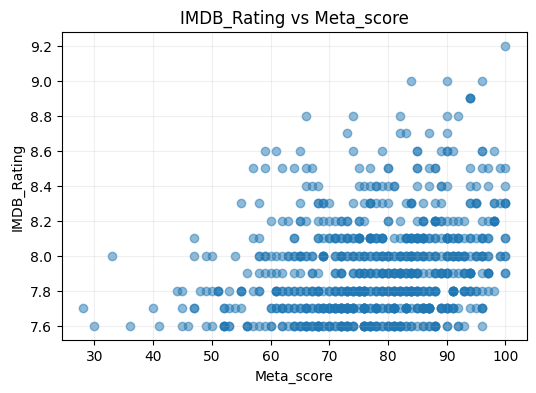

In [15]:

# IMDB_Rating vs Meta_score
fig = plt.figure(figsize=(6,4))
plt.scatter(dfc["Meta_score"], dfc["IMDB_Rating"], alpha=0.5)
plt.title("IMDB_Rating vs Meta_score")
plt.xlabel("Meta_score")
plt.ylabel("IMDB_Rating")
plt.grid(True, alpha=0.2)
plt.show()


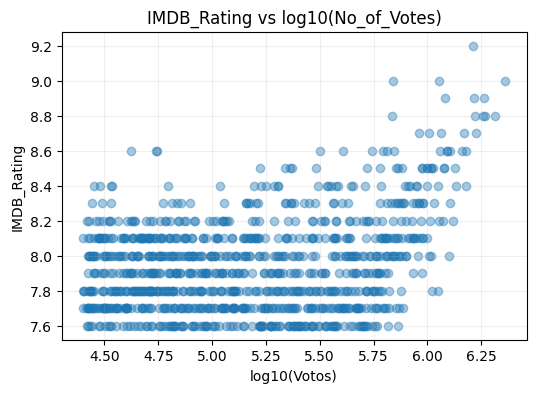

In [16]:

# IMDB_Rating vs No_of_Votes (escala log em X)
fig = plt.figure(figsize=(6,4))
x = dfc["No_of_Votes"].astype(float)
y = dfc["IMDB_Rating"].astype(float)
mask = (x>0) & y.notna()
plt.scatter(np.log10(x[mask]), y[mask], alpha=0.4)
plt.title("IMDB_Rating vs log10(No_of_Votes)")
plt.xlabel("log10(Votos)")
plt.ylabel("IMDB_Rating")
plt.grid(True, alpha=0.2)
plt.show()


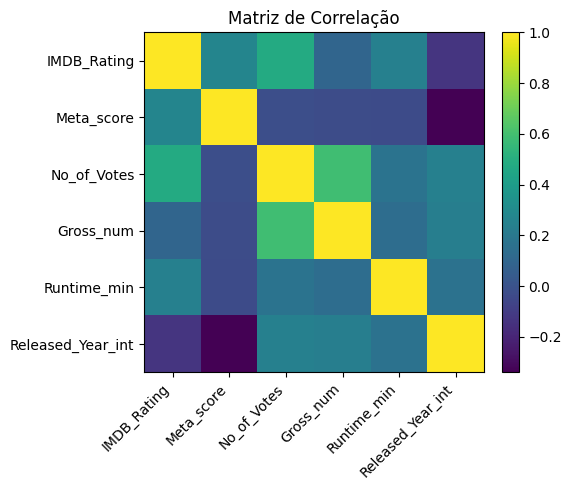

,IMDB_Rating,Meta_score,No_of_Votes,Gross_num,Runtime_min,Released_Year_int
IMDB_Rating,1.000000,0.271374,0.479308,0.099393,0.242751,-0.133257
Meta_score,0.271374,1.000000,-0.020091,-0.030480,-0.031604,-0.339291
No_of_Votes,0.479308,-0.020091,1.000000,0.589527,0.172483,0.246005
Gross_num,0.099393,-0.030480,0.589527,1.000000,0.140002,0.233270
Runtime_min,0.242751,-0.031604,0.172483,0.140002,1.000000,0.165765
Released_Year_int,-0.133257,-0.339291,0.246005,0.233270,0.165765,1.000000


In [17]:

# Correlação das colunas numéricas
num_cols = ["IMDB_Rating", "Meta_score", "No_of_Votes", "Gross_num", "Runtime_min", "Released_Year_int"]
corr = dfc[num_cols].corr(method="pearson", numeric_only=True)
fig = plt.figure(figsize=(6,5))
im = plt.imshow(corr, cmap="viridis")
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.xticks(range(len(num_cols)), num_cols, rotation=45, ha="right")
plt.yticks(range(len(num_cols)), num_cols)
plt.title("Matriz de Correlação")
plt.tight_layout()
plt.show()
corr



## 5. Cortes por Gênero e Certificado


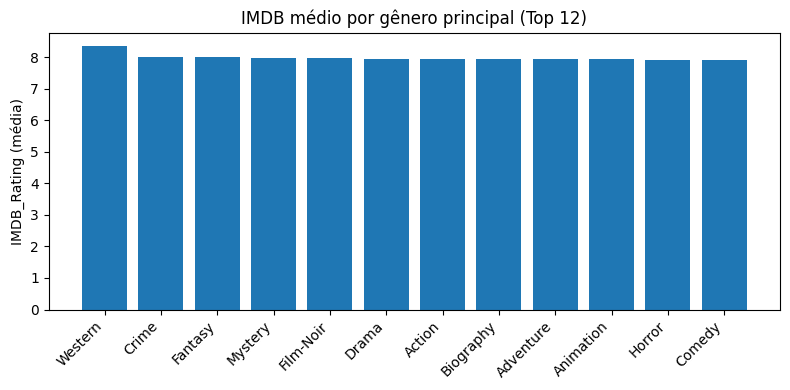

Genre_Primary
Western      8.350000
Crime        8.016822
Fantasy      8.000000
Mystery      7.975000
Film-Noir    7.966667
Drama        7.952778
Action       7.949419
Biography    7.938636
Adventure    7.937500
Animation    7.930488
Horror       7.909091
Comedy       7.901290
Name: IMDB_Rating, dtype: float64

In [18]:

# Média de IMDB por gênero principal (Top N gêneros por contagem)
top_genres = dfc["Genre_Primary"].value_counts().head(12).index.tolist()
g = (dfc[dfc["Genre_Primary"].isin(top_genres)]
     .groupby("Genre_Primary")["IMDB_Rating"].mean()
     .sort_values(ascending=False))

fig = plt.figure(figsize=(8,4))
plt.bar(g.index, g.values)
plt.title("IMDB médio por gênero principal (Top 12)")
plt.xticks(rotation=45, ha="right")
plt.ylabel("IMDB_Rating (média)")
plt.tight_layout()
plt.show()
g


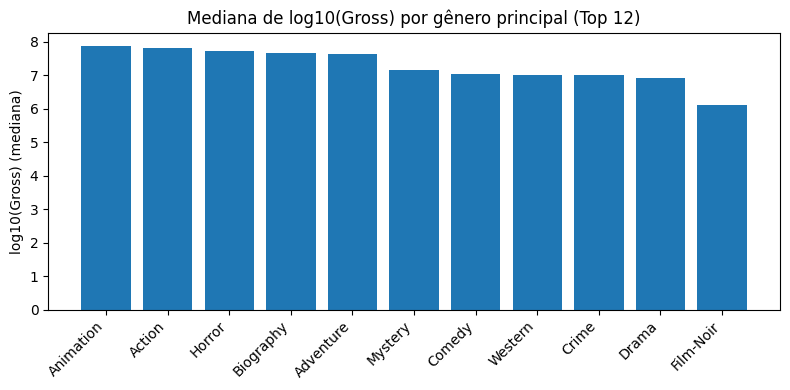

Genre_Primary
Animation    75082668.0
Action       66208183.0
Horror       51500184.5
Biography    46836394.0
Adventure    44824144.0
Mystery      14378331.0
Comedy       10728127.0
Western      10550000.0
Crime        10095170.0
Drama         8264530.0
Film-Noir     1278625.5
Fantasy             NaN
Name: Gross_num, dtype: float64

In [19]:

# Mediana de Gross por gênero principal
g2 = (dfc[dfc["Genre_Primary"].isin(top_genres)]
      .groupby("Genre_Primary")["Gross_num"].median()
      .sort_values(ascending=False))

fig = plt.figure(figsize=(8,4))
plt.bar(g2.index, np.log10(g2.replace(0, np.nan)))
plt.title("Mediana de log10(Gross) por gênero principal (Top 12)")
plt.xticks(rotation=45, ha="right")
plt.ylabel("log10(Gross) (mediana)")
plt.tight_layout()
plt.show()
g2


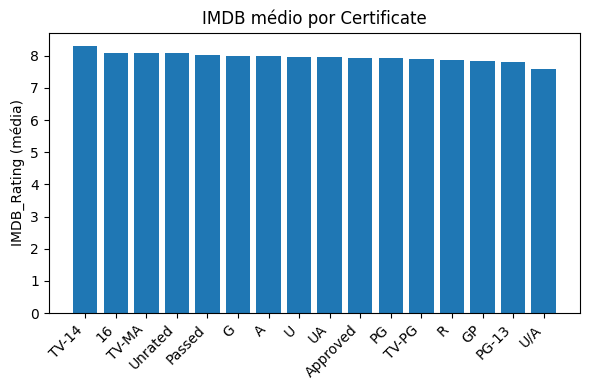

Certificate
TV-14       8.300000
16          8.100000
TV-MA       8.100000
Unrated     8.100000
Passed      8.020588
G           8.000000
A           7.992347
U           7.976923
UA          7.957143
Approved    7.945455
PG          7.927027
TV-PG       7.900000
R           7.869863
GP          7.850000
PG-13       7.797674
U/A         7.600000
Name: IMDB_Rating, dtype: float64

In [20]:

# IMDB médio por Certificate
cert = (dfc.groupby("Certificate")["IMDB_Rating"].mean()
        .sort_values(ascending=False))

fig = plt.figure(figsize=(6,4))
plt.bar(cert.index.astype(str), cert.values)
plt.title("IMDB médio por Certificate")
plt.xticks(rotation=45, ha="right")
plt.ylabel("IMDB_Rating (média)")
plt.tight_layout()
plt.show()
cert



## 6. Diretores e Elenco


In [21]:

# Diretores com pelo menos N filmes e maior IMDB médio
N_MIN = 2
dir_stats = (dfc.dropna(subset=["Director"])
               .groupby("Director")
               .agg(n_filmes=("Series_Title","count"),
                    imdb_mean=("IMDB_Rating","mean"))
               .query("n_filmes >= @N_MIN")
               .sort_values(["imdb_mean","n_filmes"], ascending=[False, False])
               .head(15))
dir_stats


,n_filmes,imdb_mean
Director,,
Milos Forman,2,8.500000
Christopher Nolan,8,8.462500
Francis Ford Coppola,5,8.400000
Peter Jackson,5,8.400000
Charles Chaplin,6,8.333333
Fritz Lang,2,8.300000
Lee Unkrich,2,8.300000
Nitesh Tiwari,2,8.300000
Sergio Leone,6,8.266667


In [22]:

# Atores/atrizes – consolidar em uma única coluna para contagem
stars_cols = ["Star1","Star2","Star3","Star4"]
stacked = pd.concat([dfc[c].rename("Star") for c in stars_cols], axis=0)
star_stats = (stacked.dropna()
                     .to_frame()
                     .assign(IMDB=dfc["IMDB_Rating"].reindex(stacked.index, method="ffill"))
                     .groupby("Star")
                     .agg(n=("IMDB","count"),
                          imdb_mean=("IMDB","mean"))
                     .query("n >= 3")
                     .sort_values(["imdb_mean","n"], ascending=[False, False])
                     .head(15))
star_stats


,n,imdb_mean
Star,,
Elijah Wood,3,8.800000
Orlando Bloom,4,8.600000
Mark Hamill,3,8.533333
Madhavan,3,8.466667
Marlon Brando,4,8.425000
Lee J. Cobb,3,8.366667
Charles Chaplin,6,8.333333
James Caan,3,8.333333
Kevin Spacey,5,8.300000



## 7. Overview: nuvem de palavras
A ideia é inspecionar termos mais frequentes em **filmes com notas altas** vs **notas baixas**.


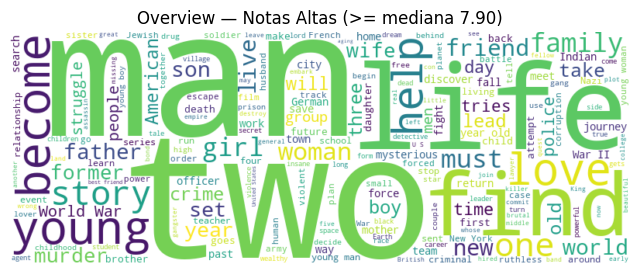

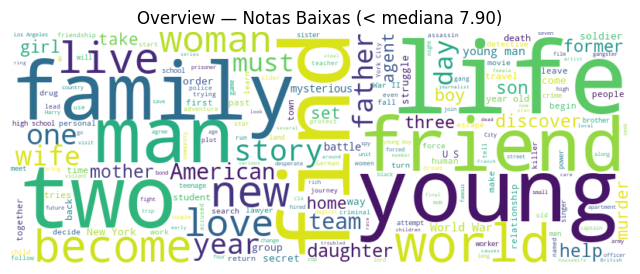

In [23]:

def make_wordcloud(text, title="WordCloud"):
    fig = plt.figure(figsize=(8,4))
    wc = WordCloud(width=800, height=300, background_color="white").generate(text)
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(title)
    plt.show()

# Splits por IMDB_Rating
threshold = dfc["IMDB_Rating"].median()
high = " ".join(dfc.loc[dfc["IMDB_Rating"] >= threshold, "Overview"].dropna().astype(str))
low  = " ".join(dfc.loc[dfc["IMDB_Rating"] <  threshold, "Overview"].dropna().astype(str))

if len(high) > 0:
    make_wordcloud(high, title=f"Overview — Notas Altas (>= mediana {threshold:.2f})")
if len(low) > 0:
    make_wordcloud(low,  title=f"Overview — Notas Baixas (< mediana {threshold:.2f})")



## 8. NLP rápido: é possível inferir o gênero a partir da Overview?
Sim. Abaixo, um baseline com **TF-IDF + Regressão Logística** prevendo o **gênero principal** a partir da sinopse.


In [24]:

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

nlp_df = dfc.dropna(subset=["Overview","Genre_Primary"]).copy()
X_text = nlp_df["Overview"].astype(str)
y_genre = nlp_df["Genre_Primary"].astype(str)

pipe = make_pipeline(
    TfidfVectorizer(max_features=5000, ngram_range=(1,2)),
    LogisticRegression(max_iter=200, n_jobs=None)
)

scores = cross_val_score(pipe, X_text, y_genre, cv=5, scoring="accuracy")
print("Acurácias (cv=5):", np.round(scores, 3))
print("Acurácia média:", scores.mean().round(3))


Acurácias (cv=5): [0.345 0.34  0.335 0.34  0.337]
Acurácia média: 0.339



## 9. Hipóteses iniciais
- **H1**: Filmes do gênero **Drama** tendem a ter **notas IMDb mais altas**, mas **bilheteria mediana** menor do que gêneros de ação/aventura.
- **H2**: **No_of_Votes** (popularidade) está **positivamente** relacionado com **Gross** e com a **nota IMDb** (efeito de sobrevivência e boca a boca).
- **H3**: **Meta_score** tem **correlação positiva** com **IMDB_Rating** (crítica especializada influencia percepção do público).
- **H4**: **Certificate** do tipo **PG-13** tende a **maximizar bilheteria** por atingir um público mais amplo.
- **H5**: É possível **inferir o gênero** do filme a partir da **Overview** com acurácia superior ao acaso usando TF-IDF (e potencialmente melhor com embeddings).



## 10. Próximos passos
1. Refinar limpeza de dados (tratamento robusto de `Gross`, `Runtime`, outliers).
2. Enriquecer com dados externos (orçamento, prêmios, janela de lançamento / sazonalidade).
3. Testar diferentes modelos para prever **IMDB_Rating** (regressão): Regressão Linear, Random Forest, Gradient Boosting.
4. Medir performance com **RMSE/MAE** e validação cruzada.
5. Gerar **relatório** consolidado (exportar HTML/PDF) para stakeholders da PProductions.
